# Imports

In [1]:
%matplotlib inline

import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
sys.path.append("../models/slim")

# Tensorflow
import tensorflow as tf
slim = tf.contrib.slim
from nets import inception
from preprocessing import inception_preprocessing
from datasets import imagenet

# Third-party
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import numpy as np
import time

# LIME
from lime import lime_image

# Data

In [2]:
DATA_DIR = '/localdata/nikhil/ILSVRC2012_img_val/'
FILE_NUM = 12

file_list = os.listdir(DATA_DIR)
file_list_len = len(file_list)

# file_idx = np.random.randint(0,file_list_len, size=(FILE_NUM))

# Initializations

In [3]:
session_inception = tf.Session()
session_resnet = tf.Session()

image_size_inception = inception.inception_v3.default_image_size
image_size_resnet = inception.inception_resnet_v2.default_image_size

In [4]:
def transform_img_fn(path_list, image_size, session):
    out = []
    for f in path_list:
        image_raw = tf.image.decode_jpeg(open(f).read(), channels=3)
        image = inception_preprocessing.preprocess_image(image_raw, image_size, image_size, is_training=False)
        out.append(image)
    return session.run([out])[0]

In [5]:
names = imagenet.create_readable_names_for_imagenet_labels()
processed_images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

In [6]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits_inception, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
probabilities_inception = tf.nn.softmax(logits_inception)

with slim.arg_scope(inception.inception_resnet_v2_arg_scope()):
    logits_resnet, _ = inception.inception_resnet_v2(processed_images, num_classes=1001, is_training=False)
probabilities_resnet = tf.nn.softmax(logits_resnet)

In [7]:
checkpoints_dir = "../models/slim/pretrained"

init_fn_inception = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, "inception_v3.ckpt"),
    slim.get_model_variables("InceptionV3"))
init_fn_inception(session_inception)

init_fn_resnet = slim.assign_from_checkpoint_fn(
    os.path.join(checkpoints_dir, "inception_resnet_v2.ckpt"),
    slim.get_model_variables("InceptionResnetV2"))
init_fn_resnet(session_resnet)

In [8]:
def predict_fn_inception(images):
    return session_inception.run(probabilities_inception, feed_dict={processed_images: images})

def predict_fn_resnet(images):
    return session_resnet.run(probabilities_resnet, feed_dict={processed_images: images})

# Base Classifier and Lime explanations for the top class

File = ILSVRC2012_val_00044069.JPEG
  Inception: 791
  Resnet: 791
File = ILSVRC2012_val_00010947.JPEG
  Inception: 983
  Resnet: 983
File = ILSVRC2012_val_00038276.JPEG
  Inception: 360
  Resnet: 360
File = ILSVRC2012_val_00024949.JPEG
  Inception: 603
  Resnet: 603
File = ILSVRC2012_val_00041278.JPEG
  Inception: 843
  Resnet: 843
File = ILSVRC2012_val_00045507.JPEG
  Inception: 339
  Resnet: 339
File = ILSVRC2012_val_00006412.JPEG
  Inception: 663
  Resnet: 663
File = ILSVRC2012_val_00001789.JPEG
  Inception: 764
  Resnet: 764
File = ILSVRC2012_val_00027217.JPEG
  Inception: 216
  Resnet: 216
File = ILSVRC2012_val_00015524.JPEG
  Inception: 577
  Resnet: 577
File = ILSVRC2012_val_00024564.JPEG
  Inception: 229
  Resnet: 229
File = ILSVRC2012_val_00017632.JPEG
  Inception: 813
  Resnet: 813


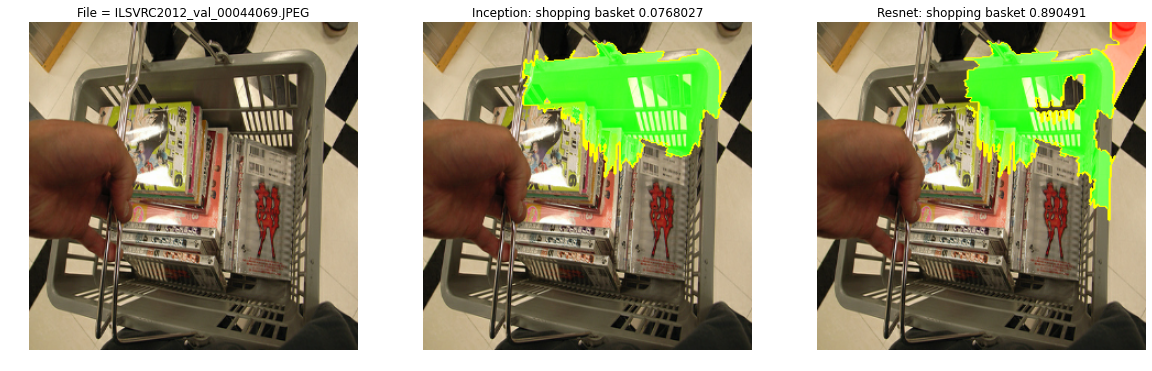

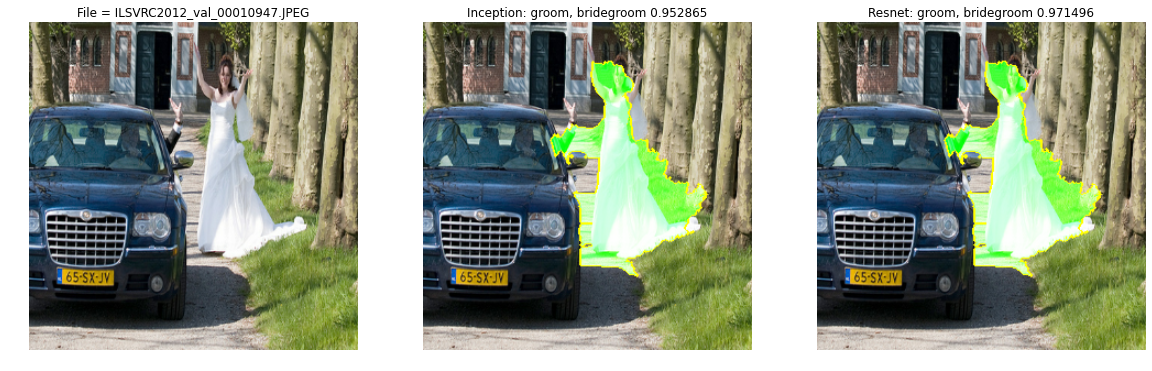

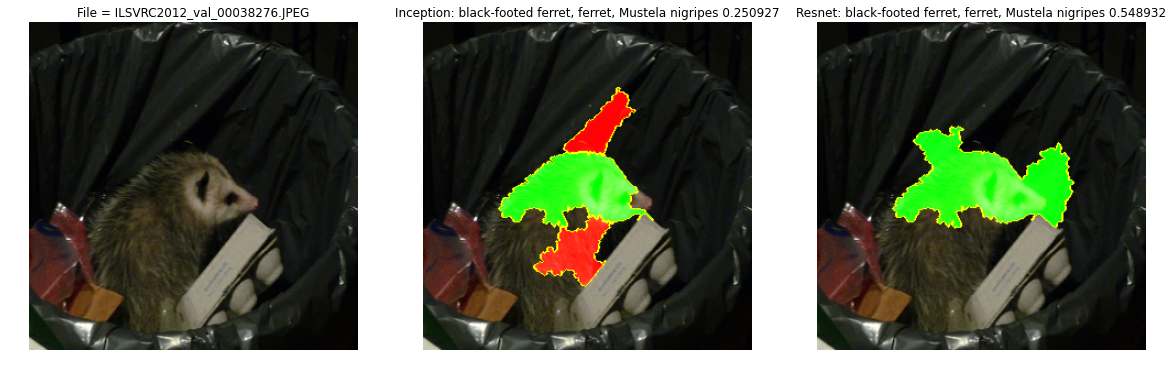

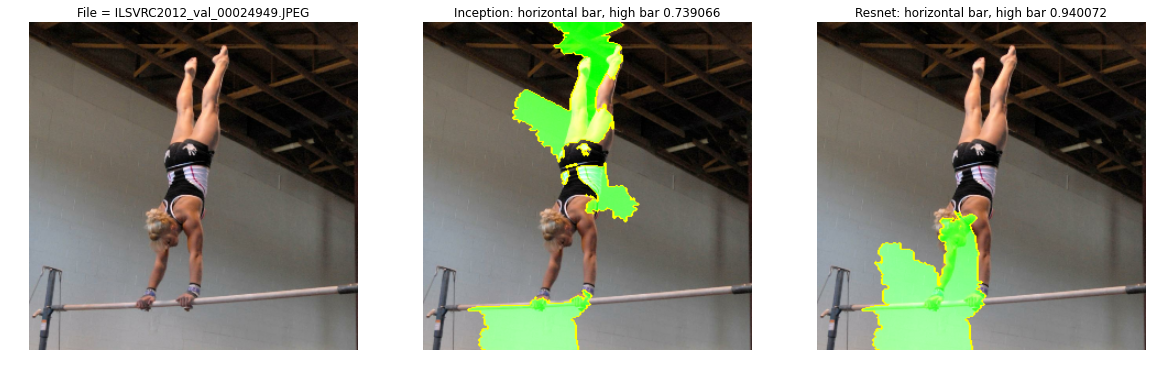

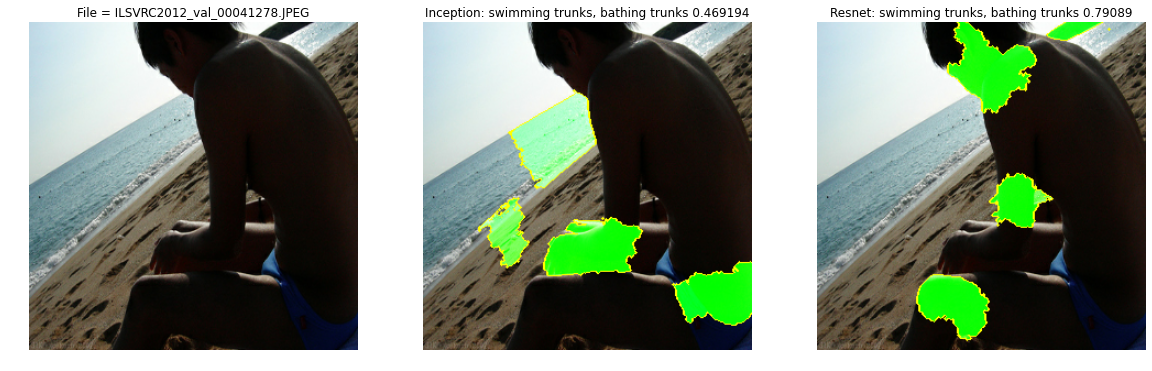

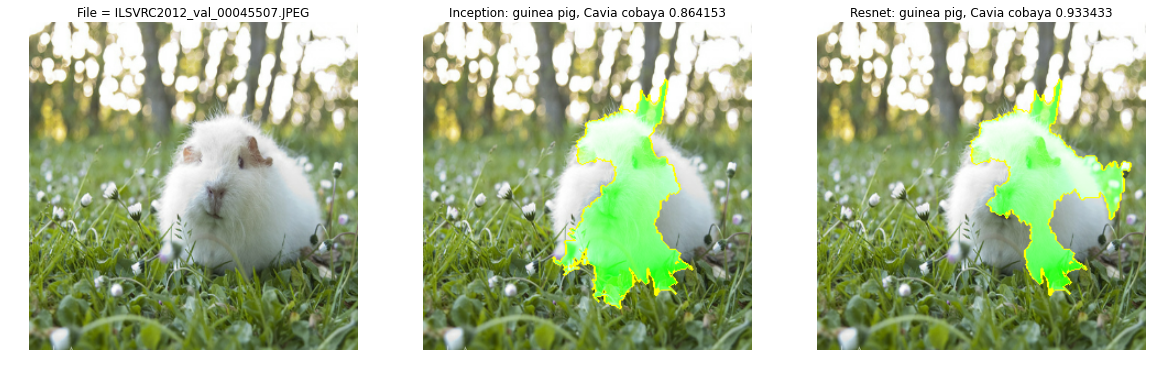

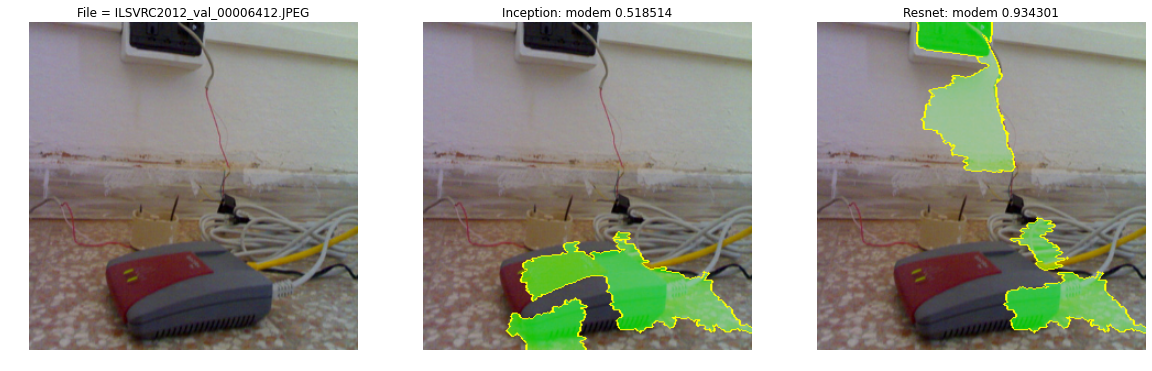

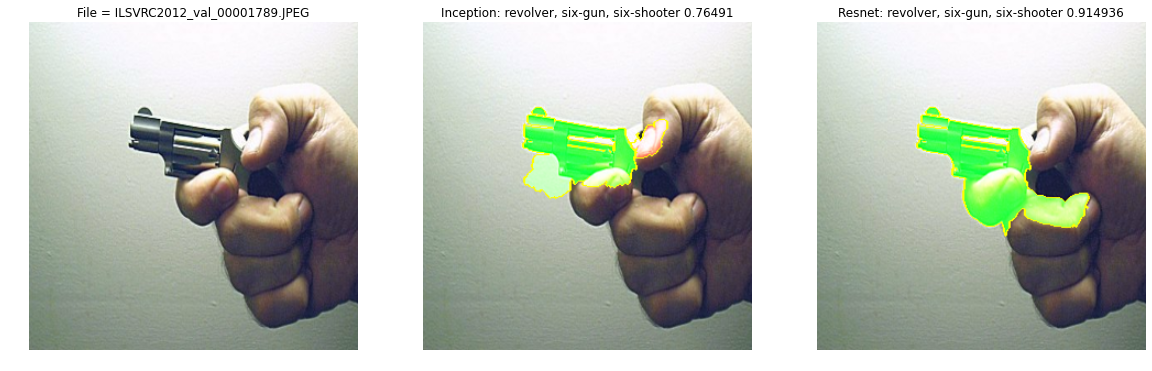

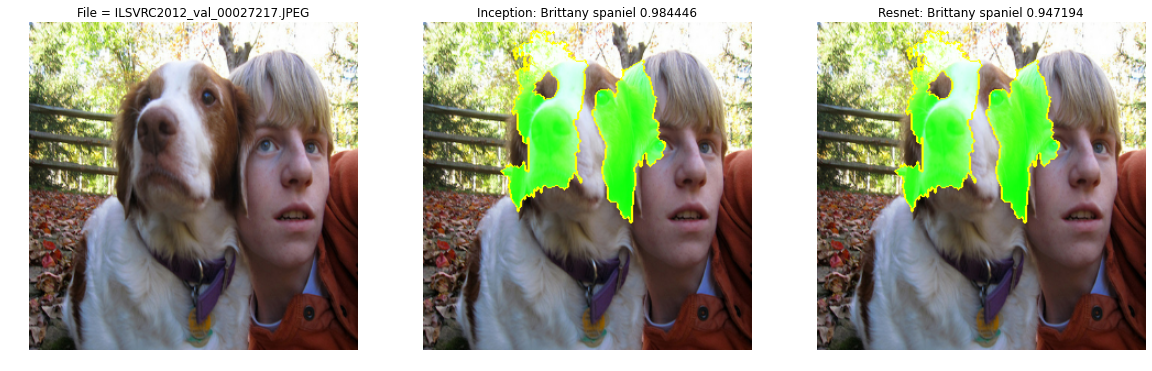

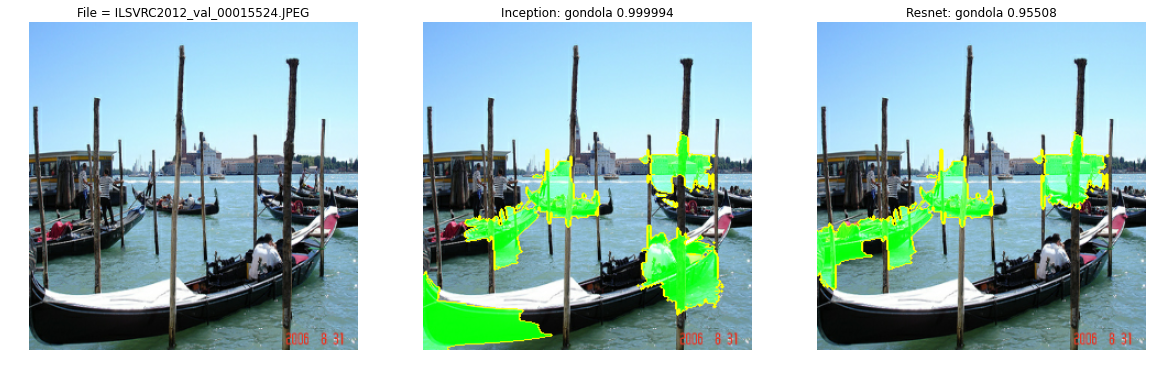

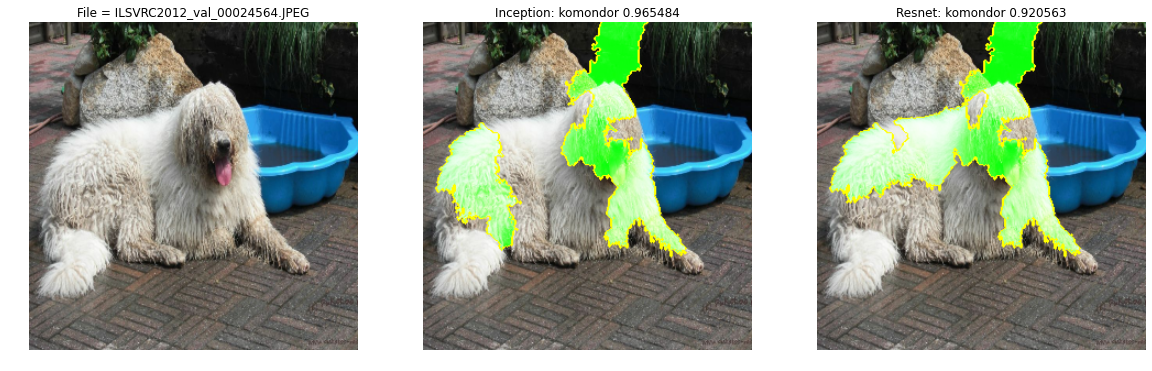

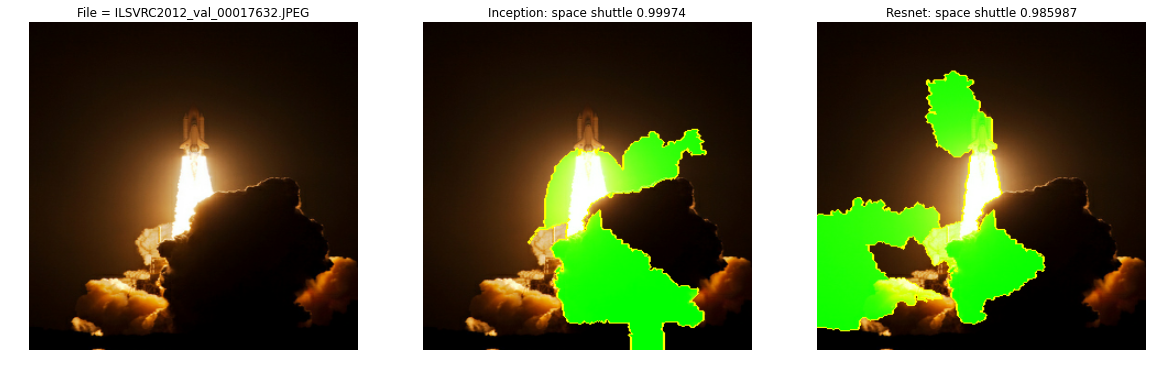

In [9]:
file_count = 0

while(file_count < FILE_NUM):
    idx = np.random.randint(0,file_list_len)
    
    if file_list[idx].endswith(".JPEG"):
        infile_path = os.path.join(DATA_DIR, file_list[idx])
#         print('File = ' + str(file_list[idx]))
        
        
        # Base Classifiers
        images_inception = transform_img_fn([infile_path], image_size_inception, session_inception)
        preds_inception = predict_fn_inception(images_inception)
        preds_inception_top = preds_inception.argsort()[0][-1]
#         print('  Inception: ' + str(preds_inception_top))
        
        images_resnet = transform_img_fn([infile_path], image_size_resnet, session_resnet)
        preds_resnet = predict_fn_resnet(images_resnet)
        preds_resnet_top = preds_resnet.argsort()[0][-1]
#         print('  Resnet: ' + str(preds_resnet_top))
        
        if(preds_inception_top == preds_resnet_top):
            print('File = ' + str(file_list[idx]))
            print('  Inception: ' + str(preds_inception_top))
            print('  Resnet: ' + str(preds_resnet_top))
            
        
            # Lime Explainers
            image_inception = images_inception[0]
            explainer_inception = lime_image.LimeImageExplainer()
            explanation_inception = explainer_inception.explain_instance(image_inception, 
                                                                         predict_fn_inception, 
                                                                         top_labels=5, 
                                                                         hide_color=0, 
                                                                         num_samples=1000)

            image_resnet = images_resnet[0]
            explainer_resnet = lime_image.LimeImageExplainer()
            explanation_resnet = explainer_resnet.explain_instance(image_resnet, 
                                                                   predict_fn_resnet, 
                                                                   top_labels=5, 
                                                                   hide_color=0, 
                                                                   num_samples=1000)


            # Explanations for the top class
            temp_inception, mask_inception = explanation_inception.get_image_and_mask(preds_inception_top, 
                                                                                      positive_only=False, 
                                                                                      num_features=5, 
                                                                                      hide_rest=False)
            temp_resnet, mask_resnet = explanation_resnet.get_image_and_mask(preds_resnet_top, 
                                                                             positive_only=False, 
                                                                             num_features=5, 
                                                                             hide_rest=False)

            # Plots
            f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 60))
            ax1.axis('off'); ax2.axis('off'); ax3.axis('off')


            ax1.imshow(image_inception / 2 + 0.5)
            ax1.set_title('File = ' + str(file_list[idx]))

            ax2.imshow(mark_boundaries(temp_inception / 2 + 0.5, mask_inception))
            ax2.set_title('Inception: ' 
                          + str(names[preds_inception_top]) 
                          + str(' ') 
                          + str(preds_inception[0,preds_inception_top]))

            ax3.imshow(mark_boundaries(temp_resnet / 2 + 0.5, mask_resnet))
            ax3.set_title('Resnet: ' 
                          + str(names[preds_resnet_top])
                          + str(' ') 
                          + str(preds_resnet[0,preds_resnet_top]))
            
            file_count = file_count+1